# Decision Tree Candy Machine

### Explore a Wuzzle simulation


In [1]:
import os
from os import path

import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from scipy.stats import norm
from src.simulation import Simulation
from helpers import *
from src.machine import Machine


plt.style.use('seaborn-bright')



strategy="decision_tree"
strategy_human = "Decision Tree Machine"
image_prefix = "images/dt_"
num_simulations=10

if path.exists(f"models/{strategy}.joblib"):
    os.remove(f"models/{strategy}.joblib")

machine_object = Machine(strategy=strategy)
print(type(machine_object))

s = Simulation(machine_object)


simulations, nights_df = run_strat(
    machine_object=machine_object, 
    num_simulations=num_simulations,
    image_prefix = image_prefix
)

<class 'src.machine.Machine'>
<class 'src.machine.Machine'>


## Taking a look at our decision tree....

In [2]:
from src.models.tree import DecisionTree

world_tree = DecisionTree()
print(world_tree.model.model_description())


None


In [3]:
world_tree.model.model_measurements

{'Tree size (nodes)': 0,
 'Tree size (leaves)': 0,
 'Active learning nodes': 0,
 'Tree depth': 0,
 'Active leaf byte size estimate': 0.0,
 'Inactive leaf byte size estimate': 0.0,
 'Byte size estimate overhead': 1.0}

In [4]:
# world_tree.model.draw()

### Take a quick look at the data for each night in the land of Wuzz

In [5]:
nights_df.head()

,nightly_lick_counter,lick_counter,population_wuzzle,dead_wuzzle,live_wuzzle,total_hunger_wuzzle,population_candy,dead_candy,live_candy,total_hunger_candy,machine_accuracy
0,0,0,50,0,50,0.0,50,0,50,0.0,0.0
1,85,85,50,0,50,1250.0,50,0,50,50.0,0.0
2,93,178,50,0,50,1300.0,50,0,50,56.0,0.0
3,98,276,50,0,50,1400.0,50,0,50,54.0,0.0
4,112,388,50,1,49,1375.0,50,0,50,58.0,0.0


# Population Over Time

Due to the current rules of Wuzz, the populations eventually die because there is no recycling and there are no new Wuzzles or Candy being introduced. 

The question is how long it takes.

This first graphic shows the living Wuzzle populations over time. Each pale green line is the data from a single world, and the thick orange line shows the average of all worlds.

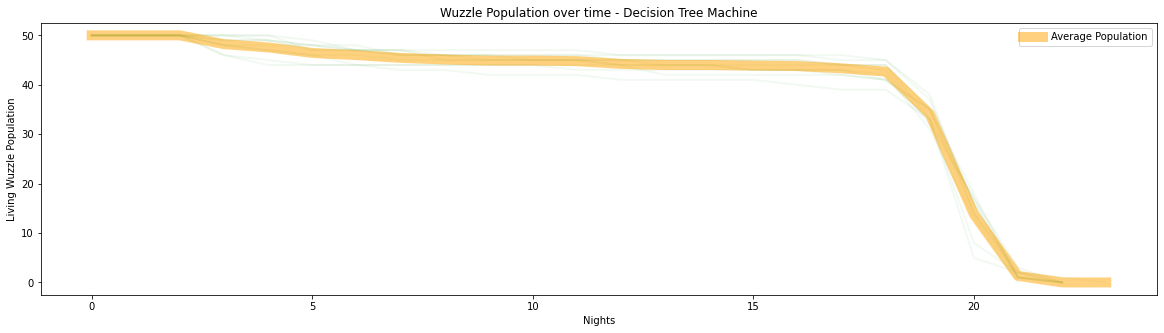

In [6]:
plt.figure(figsize=(20, 5))

nights_arr = []
max_nights = 0

i = 0
for sim in simulations:
    sim_stats = pd.DataFrame(sim.nightly_stats)
    plt.plot(sim_stats['live_wuzzle'], color='green', alpha=.05, linewidth=2)

    if len(sim_stats) > max_nights:
        max_nights = len(sim_stats)
    nights_arr.append(np.array(sim_stats['live_wuzzle'].values))


uniform_arr = []
for n in nights_arr:
    c_nights = len(n)
    diff = max_nights - c_nights

    if len(n) < max_nights:
        diff_add = np.zeros(diff)
        n = np.concatenate((n, diff_add)) 
        uniform_arr.append(n)  

x = np.stack(uniform_arr)
x = x.T
# x[:][15].mean()

averages_arr = []

i = 0
for night in x[:]:
    averages_arr.append(x[:][i].mean())
    i += 1

averages_arr

plt.plot(averages_arr, color='orange', alpha=.5, linewidth=10, label="Average Population")
plt.title(f"Wuzzle Population over time - {strategy_human}")
plt.ylabel('Living Wuzzle Population')
plt.xlabel('Nights')

plt.legend()
plt.savefig(f"{ image_prefix }wuzzle_population_over_time.png");
plt.show();

maximum_number_of_nights = max_nights

## Looking at the distribution of the number of days until all Wuzzles are dead:

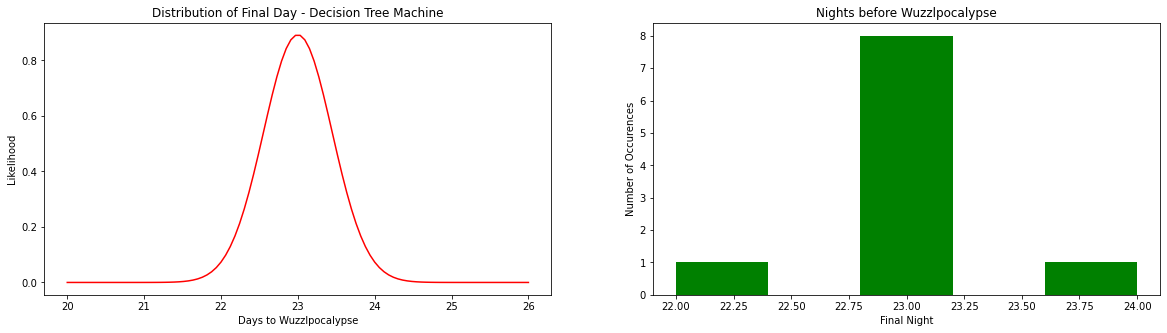

In [7]:
# using tuple unpacking for multiple Axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

max_nights = []

for sim in simulations:
    nights_df = pd.DataFrame(sim.nightly_stats)
    max_nights.append(len(nights_df))

max_nights = np.array(max_nights)

global_nights_mean = max_nights.mean()
global_nights_min = max_nights.min()
global_nights_max = max_nights.max()


dist = norm(loc=max_nights.mean(), scale=max_nights.std())

spread = max_nights.max() - max_nights.min()
support = np.linspace(max_nights.min() - spread, max_nights.max() + spread, 100)

ax1.plot(support, dist.pdf(support), color='red')
ax1.set_title(f"Distribution of Final Day - {strategy_human}")
ax1.set_ylabel('Likelihood')
ax1.set_xlabel('Days to Wuzzlpocalypse')

ax2.hist(max_nights, facecolor='green', alpha=1, bins=5)
ax2.set_ylabel('Number of Occurences')
ax2.set_xlabel('Final Night')
ax2.set_title('Nights before Wuzzlpocalypse')

plt.savefig(f"{ image_prefix }distribution_final_days.png");
plt.show();

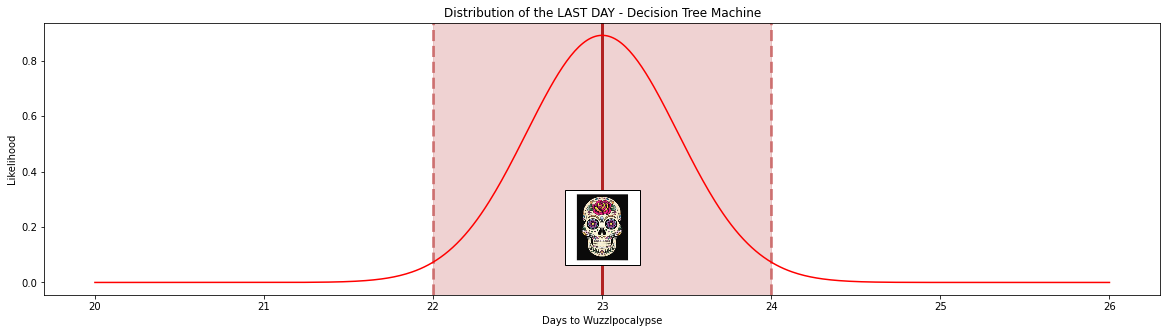

In [8]:
nrml_dist_points = skull_chart(simulations, strategy_human, image_prefix)

# Licks: What is happening leading to the disaster?

### We start by looking at the total number of licks in each world.

You can see it start low, and then move up steadily until the available resources are used up. Then it tops off and everyone starves.

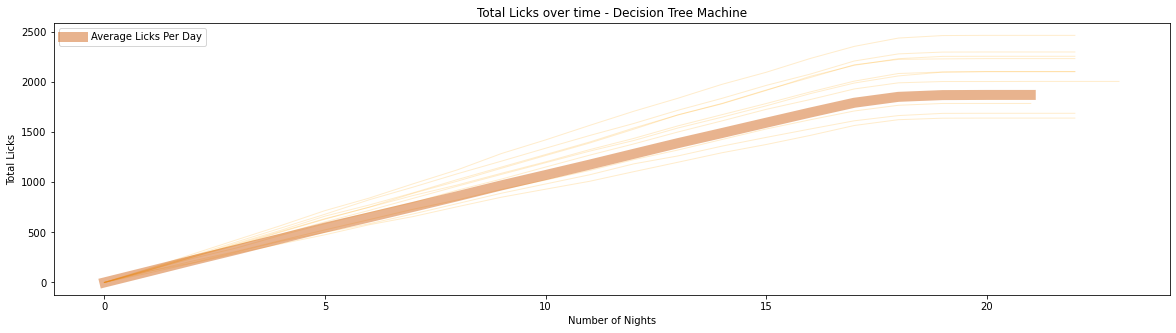

In [9]:
plt.figure(figsize=(20, 5))

y_size = num_simulations
x_size = maximum_number_of_nights

all_licks = np.zeros((y_size+1,x_size+1))

y = 0

for sim in simulations:
    nights_df = pd.DataFrame(sim.nightly_stats)
    plt.plot(nights_df['lick_counter'], color='orange', alpha=.2, linewidth=1)
    x = 0

    # print(all_licks.shape)
    for p in nights_df['lick_counter']:
        x+=1
        all_licks[y][x] = p
    y += 1

# all_licks = all_licks.T

lick_means = []

for l in all_licks.T:
    lick_means.append(l.mean())

global_nights_mean_int = int(global_nights_mean)

plt.plot(lick_means[1:global_nights_mean_int], color='chocolate', alpha=.5, linewidth=10, label="Average Licks Per Day")


plt.title(f"Total Licks over time - {strategy_human}")
plt.ylabel('Total Licks')
plt.xlabel('Number of Nights')
plt.legend()

plt.savefig(f"{ image_prefix }total_licks.png");
plt.show();

## Licks per Day

Looking at licks each Day, we can see that early on licks are steady, then they drop as supply goes down. Eventually they drop to nothing and again, everyone starves.

This graph shows the range of final days to the right with the red bars.

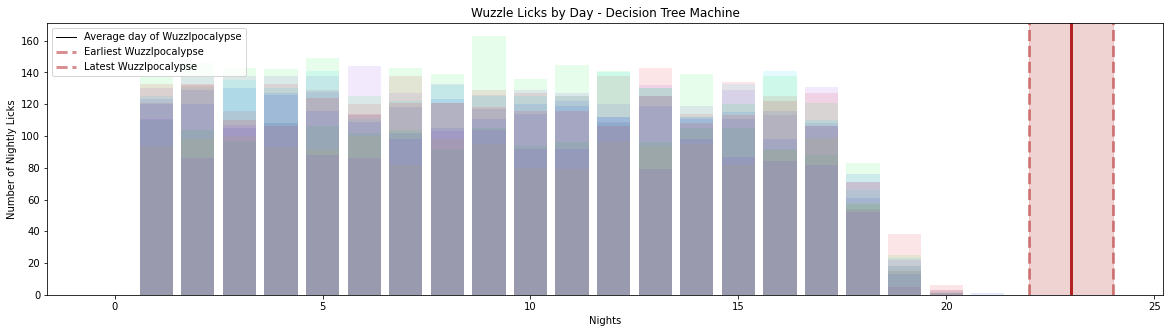

In [10]:
plt.figure(figsize=(20, 5))

for sim in simulations:
    nights_df = pd.DataFrame(sim.nightly_stats)
    support = list(range(len(nights_df)))
    
    plt.bar(height=nights_df['nightly_lick_counter'], x=support, alpha=.1)

# plt.vlines(global_nights_mean)
plt.axvline(global_nights_mean, color="black", linewidth=1, alpha=1, label="Average day of Wuzzlpocalypse")
plt.axvline(global_nights_mean, color="firebrick", linewidth=3, alpha=1)
plt.axvline(global_nights_min, linestyle ="--", color="firebrick", linewidth=3, alpha=.5, label="Earliest Wuzzlpocalypse")
plt.axvline(global_nights_max, linestyle ="--", color="firebrick", linewidth=3, alpha=.5, label="Latest Wuzzlpocalypse")
plt.axvspan(global_nights_min, global_nights_max, alpha=0.2, color='firebrick')


plt.title(f"Wuzzle Licks by Day - {strategy_human}")
plt.ylabel(f"Number of Nightly Licks")
plt.xlabel('Nights')

plt.legend()
plt.savefig(f"{ image_prefix }nightly_licks.png");
plt.show();

### Let's look now at model accuracy as the simulation plays out:

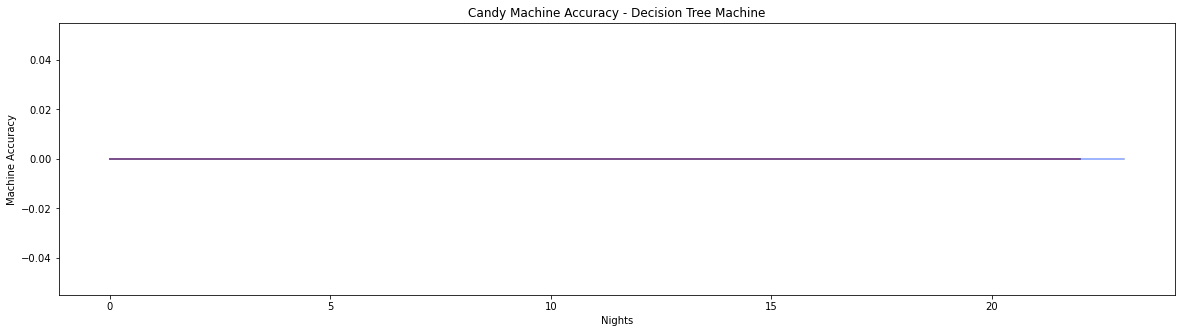

In [11]:
plt.figure(figsize=(20, 5))

for sim in simulations:
    nights_df = pd.DataFrame(sim.nightly_stats)
    support = list(range(len(nights_df)))
    
    plt.plot(nights_df['machine_accuracy'], alpha=.5)

plt.title(f"Candy Machine Accuracy - {strategy_human}")
plt.ylabel(f"Machine Accuracy")
plt.xlabel('Nights')

# plt.legend()
plt.savefig(f"{ image_prefix }machine_accuracy.png");
plt.show();